In questo esempio vorrei partire dal concetto di PCA per costruirvi sopra un modello di ml capace di adattarsi ad un dataset completamente sbilanciato (95% classe 0, 5% classe 1) e prevedere il rischio di ictus con una buona probabilità

In [1]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline as SKPipeline

from sklearn.svm import SVC
from itertools import combinations

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV # GridSearchCV
from sklearn.compose import ColumnTransformer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score, make_scorer
from collections import Counter

from sklearn.model_selection import StratifiedKFold

importo il dataset

In [2]:
stroke = pd.read_csv("../00-data/healthcare-dataset-stroke-data.csv")

stroke


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


Divido le features indipendenti dal target

In [3]:
X = stroke.drop(['stroke', 'id'], axis=1)

y = stroke['stroke'].values

Creo una prima pipeline per fare imputer e scaler in modo da rendere i dati buoni per studi e modelli

In [4]:
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include='object').columns

numerical_transformer = SKPipeline(steps=[
  ('imputer', SimpleImputer(strategy='mean')),
  ('scaler', StandardScaler())
])

categorical_transformer = SKPipeline(steps=[
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_with_imputation = ColumnTransformer(
  transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
  ])

pipeline_preprocessing = SKPipeline(steps=[
  ('preprocessor', preprocessor_with_imputation),
])


ovviamente eseguo il train test split per il futuro

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

uso la pipeline per avere dati buoni per la PCA

In [6]:
X_resampled = pipeline_preprocessing.fit_transform(X_train)

In questo momento devo esplorare i risultati, quindi evito la pipeline e mi concentro sul vedere quanto spiegano le varie componenti

In [7]:
pca = PCA(random_state=0, n_components=None)
X_train_pca = pca.fit(X_resampled)
variance_ratio = X_train_pca.explained_variance_ratio_

variance_ratio

array([2.62551277e-01, 1.30798146e-01, 1.14049640e-01, 1.06799519e-01,
       8.62286557e-02, 6.44787434e-02, 6.12228077e-02, 4.26547594e-02,
       3.70569497e-02, 2.44857681e-02, 2.37994081e-02, 2.03967377e-02,
       1.78053496e-02, 7.08373991e-03, 5.41431972e-04, 4.70664798e-05,
       4.16243782e-18, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

uso la funzione cumsum di numpy per vedere quanto spiegano le componenti principali man mano che si accumulano

In [8]:
variance_ratio_cumulative = np.cumsum(variance_ratio)

variance_ratio_cumulative

array([0.26255128, 0.39334942, 0.50739906, 0.61419858, 0.70042724,
       0.76490598, 0.82612879, 0.86878355, 0.9058405 , 0.93032627,
       0.95412567, 0.97452241, 0.99232776, 0.9994115 , 0.99995293,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

considerando le prime 11 componenti principali riusciamo a spiegare il 95% della varianza, potrebbe essere interessante questo dato considerando che mi permette di quasi dimezzare il numero di dimensioni.

Ora vado a vedere un grafico cumulativo delle dimensioni

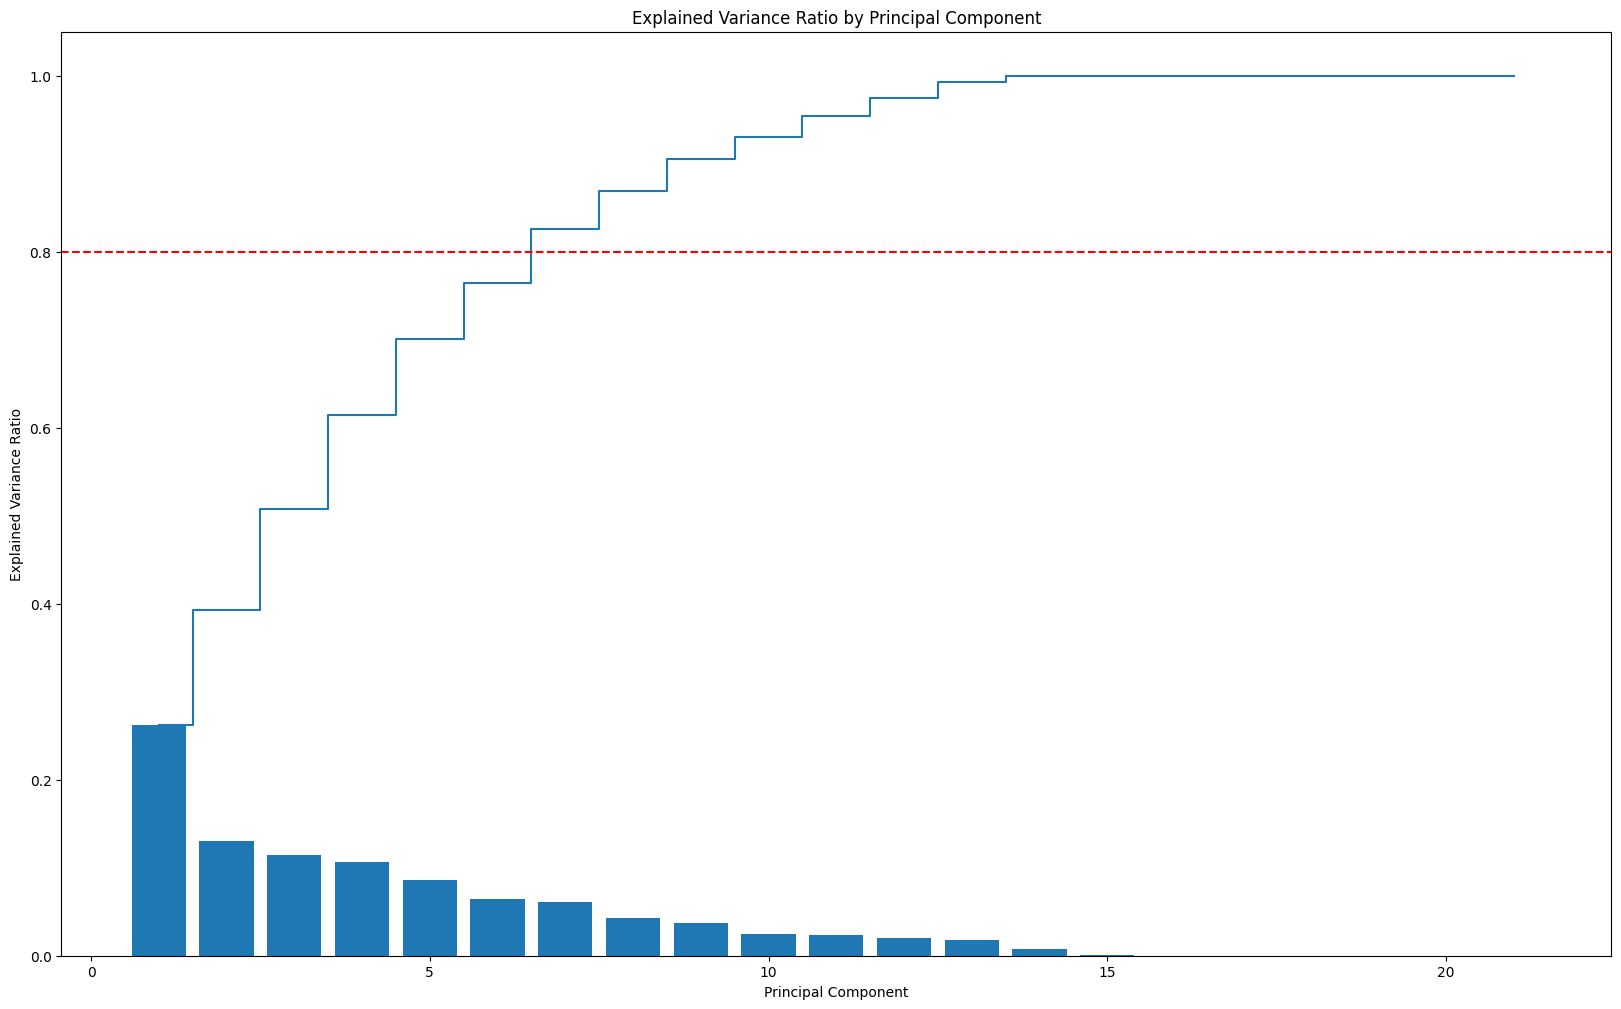

In [9]:
plt.figure(figsize=(20, 12))
plt.step(range(1, len(variance_ratio_cumulative) + 1), variance_ratio_cumulative, where='mid', label='Cumulative Explained Variance')
plt.bar(range(1, len(variance_ratio) + 1), variance_ratio, label='Explained Variance by Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.axhline(y=0.8, color='r', linestyle='--', label='95% Threshold')
plt.show()

vedo che con 11 dimensioni viene spiegato più del 95% della varianza.

La mia idea sarà addestrare un modello con le 2 dimensioni principali, poi quello con le 3, poi con le 4, 5 e così via fino ad 11 dimensioni.

Estrarre i migliori 5 modelli per ogni sottoinsieme dimensionale ed eseguire un Hard voting a 2 livelli, uno per sottospazio dimensionale dove vincerà il valore più votato e uno tra tutti i sottospazi dimensionali dove il valore sarà considerato 0 se supererà un determinato threshold

trasformo i dati

In [10]:
X_train_pca = pca.transform(X_resampled)


Creo una metrica custom per scegliere i modelli in base al valore che ritorna da essa.

Nella metrica i valori w_tp e w_tn rappresentano i pesi dati ai valori veri positivi e veri negativi, questo permette di dare più o meno peso ai risultati true positives piuttosto che true negatives in modo da dare libertà di scegliere modelli più o meno stringenti verso la classe stroke

In [11]:
def balanced_score(y_true, y_pred, w_tp=0.6, w_tn=0.4):
    cm = confusion_matrix(y_true, y_pred)

    tn, fp, fn, tp = cm.ravel()

    total_pos = tp + fn
    total_neg = tn + fp

    tpr = tp / total_pos if total_pos > 0 else 0  # Sensibilità / Recall
    tnr = tn / total_neg if total_neg > 0 else 0  # Specificità

    score = w_tp * tpr + w_tn * tnr
    return score

Questo è il core di tutto

Qui si provano tutte le combinazioni di sottospazi a n features su dei dati, si valutano con la metrica all'interno di un subset di train per trovare gli iperparametri migliori, poi tramite il dataset di test si verifica il valore e si inseriscono in un array, alla fine verranno selezionati i 5 modelli con valore più alto

In [12]:
def find_best_combination(X_train, y_train, X_test, y_test, n_components):
    class ColumnSelector(BaseEstimator, TransformerMixin):
        def __init__(self, columns):
            self.columns = columns
        def fit(self, X, y=None):
            return self
        def transform(self, X):
            return X[:, self.columns]

    models_found = []
    combs = list(combinations(range(9), n_components))

    w_tp = .6
    w_tn = 1-w_tp

    custom_scorer = make_scorer(balanced_score, w_tp=w_tp, w_tn=w_tn, greater_is_better=True)

    for i, comb in enumerate(combs):
        pipeline = SKPipeline([
            ('selector', ColumnSelector(comb)),
            ('svm', SVC(random_state=n_components, class_weight='balanced'))
        ])
        param_grid = {
            "svm__C": [0.01, 0.1, 1, 10, 100], # i parametri, 1, 10, 100 si sono rivelati i peggiori
            "svm__kernel": ['linear', 'rbf'],
            "svm__gamma": ['scale', 'auto']
        }
        cv_stratified = StratifiedKFold(n_splits=7, shuffle=True, random_state=i)

        gs = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=cv_stratified, scoring=custom_scorer, n_jobs=-1, random_state=i, n_iter=5) # scoring=custom_scorer
        
        gs.fit(X_train, y_train)
        est = gs.best_estimator_
        
        y_pred = est.predict(X_test)
        
        c_score = balanced_score(y_test, y_pred, w_tp, w_tn)

        models_found.append((i, comb, gs.best_estimator_, gs.best_params_, c_score ))
    
    sorted_models = sorted(models_found, key=lambda x: x[4], reverse=True)
    selected_models = sorted_models[:3]
    return selected_models

Qui faccio in modo che la funzione venga chiamata per ogni sottospazio

In [13]:
models = []

for i in [2,3,4,5,6,7]:
  X_secondary_split_train, X_secondary_split_test, y_secondary_split_train, y_secondary_split_test = train_test_split(X_train_pca, y_train, test_size=0.4, random_state=i)
  print(f"Testing combinations of {i} components")
  models.append(find_best_combination(X_secondary_split_train, y_secondary_split_train, X_secondary_split_test, y_secondary_split_test, i))

Testing combinations of 2 components
Testing combinations of 3 components
Testing combinations of 4 components
Testing combinations of 5 components
Testing combinations of 6 components
Testing combinations of 7 components


Qui faccio l'hard voting che attualmente è su 2 livelli

In [14]:
def hard_voting_predict_2_levels(models_3d_array, X_pca, perc_class_0=0.5):
    level1_preds = []
    
    for models_group in models_3d_array:
        all_preds_group = []
        
        for _, _, pipeline, _, _ in models_group:
            preds = pipeline.predict(X_pca)
            all_preds_group.append(preds)
        
        all_preds_group = np.array(all_preds_group)
        num_models_group = len(models_group)
        
        level1_group_preds = []
        for i in range(all_preds_group.shape[1]):
            votes = Counter(all_preds_group[:, i])
            votes_class_0 = votes.get(0, 0)
            percentage_class_0 = votes_class_0 / num_models_group

            if percentage_class_0 >= 0.5:
                level1_group_preds.append(0)
            else:
                level1_group_preds.append(1)
        
        level1_preds.append(level1_group_preds)

    level1_preds = np.array(level1_preds)
    num_groups = len(models_3d_array)
    
    final_preds = []
    for i in range(level1_preds.shape[1]):
        votes = Counter(level1_preds[:, i])
        votes_class_0 = votes.get(0, 0)
        percentage_class_0 = votes_class_0 / num_groups
        
        if percentage_class_0 >= perc_class_0:
            final_preds.append(0)
        else:
            final_preds.append(1)
            
    return np.array(final_preds)

In questa funzione faccio la valutazione finale del modello tirando fuori:
* matrice di confusione
* classification report
* roc auc curve

In [15]:
def evaluate_predictions(predictions, y_true):
    cm = confusion_matrix(y_true, predictions)
    class_names = ['Classe 0 (Nessun ictus)', 'Classe 1 (Ictus)']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d')
    plt.show()
    
    perc_true_negative = cm[0,0]*100/(cm[0,0]+cm[0,1])
    perc_true_positive = cm[1,1]*100/(cm[1,0]+cm[1,1])
    
    print(f"Percentuale di veri negativi: {perc_true_negative:.2f}%")
    print(f"Percentuale di veri positivi: {perc_true_positive:.2f}%")
    
    print(classification_report(y_true, predictions, target_names=class_names))
    print(cm)
    
    fpr, tpr, thresholds = roc_curve(y_true, predictions)
    auc = roc_auc_score(y_true, predictions)
        
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - SVM')
    plt.legend(loc='lower right')
    plt.show()
    

In [16]:
X_preprocessed_train = pipeline_preprocessing.fit_transform(X_train)

Qui invece faccio girare l'hard voting e valuto il modello sia sul dataset di train che su quello di test

In [17]:
def evaluate_on_train_test (X_train, y_train, X_test, y_test, perc_class_0):
   print(f"Percentage of class 0 in training set: {perc_class_0:.2f}")
   print("Evaluating on training set")
   
   hard_voting_train = hard_voting_predict_2_levels(models, X_train, perc_class_0=perc_class_0)
   evaluate_predictions(hard_voting_train, y_train)
   
   print("Evaluating on test set")
   X_preprocessed_test = pipeline_preprocessing.transform(X_test)

  
   hard_voting_test = hard_voting_predict_2_levels(models, X_preprocessed_test, perc_class_0=perc_class_0)
   evaluate_predictions(hard_voting_test, y_test)

Percentage of class 0 in training set: 0.70
Evaluating on training set


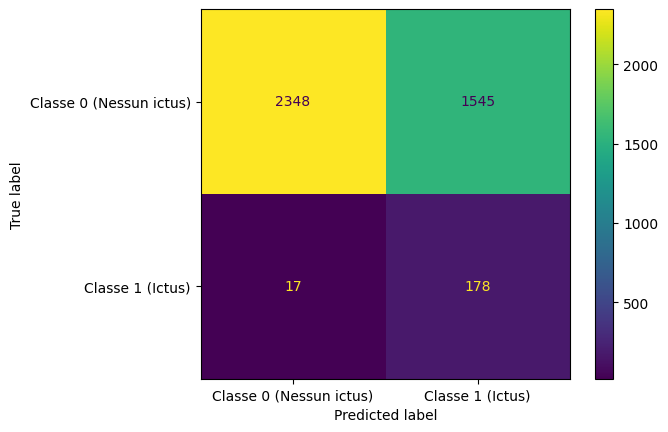

Percentuale di veri negativi: 60.31%
Percentuale di veri positivi: 91.28%
                         precision    recall  f1-score   support

Classe 0 (Nessun ictus)       0.99      0.60      0.75      3893
       Classe 1 (Ictus)       0.10      0.91      0.19       195

               accuracy                           0.62      4088
              macro avg       0.55      0.76      0.47      4088
           weighted avg       0.95      0.62      0.72      4088

[[2348 1545]
 [  17  178]]


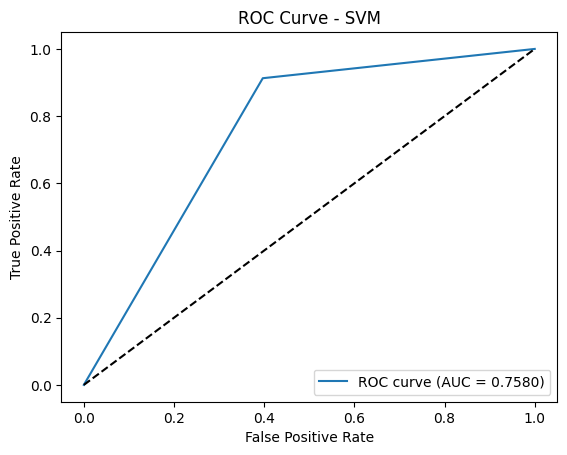

Evaluating on test set


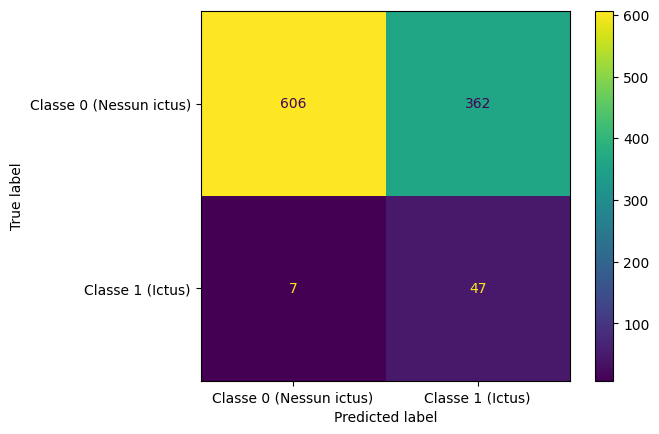

Percentuale di veri negativi: 62.60%
Percentuale di veri positivi: 87.04%
                         precision    recall  f1-score   support

Classe 0 (Nessun ictus)       0.99      0.63      0.77       968
       Classe 1 (Ictus)       0.11      0.87      0.20        54

               accuracy                           0.64      1022
              macro avg       0.55      0.75      0.48      1022
           weighted avg       0.94      0.64      0.74      1022

[[606 362]
 [  7  47]]


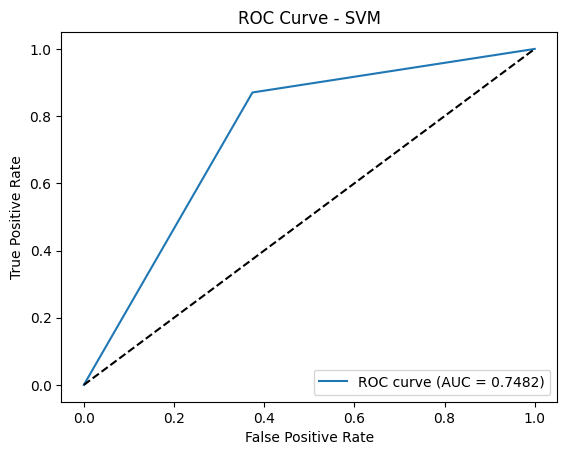

In [18]:
evaluate_on_train_test(X_preprocessed_train,y_train, X_test, y_test, perc_class_0=.7)